In [1]:
import cv2
import numpy as np

import torch
from torchvision import models

import openvino as ov

from PIL import Image
from IPython.display import display

x:\venv-ov24.0\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pt_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT, progress=True)

In [5]:
ov_model = ov.convert_model(pt_model)
ov.save_model(ov_model, 'resnet50.xml')

In [6]:
ov_model.reshape((1,3,224,224))
compiled_model = ov.compile_model(ov_model, device_name='CPU')
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[x] shape[1,3,224,224] type: f32>
]
outputs[
<ConstOutput: names[x.45] shape[1,1000] type: f32>
]>

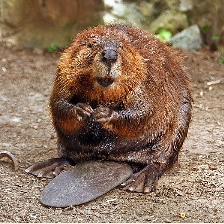

(1, 3, 224, 224)

In [9]:
img = cv2.imread('beaver.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
display(Image.fromarray(img))
img = img.astype(np.float32) / 255.0 - 0.5
img = np.transpose(img, (2,0,1))
img = np.expand_dims(img, axis=0)
img.shape

In [10]:
result = compiled_model.infer_new_request(img)
result = result[0].ravel()
print(result.shape, result[:40])

(1000,) [-0.20378555 -0.15519938 -0.1635655   0.03580582 -0.02331232  0.3830955
 -0.11993279  0.18953428  0.50523853 -0.11326528 -0.19872877 -0.09809065
 -0.03348687  0.227216   -0.13436583 -0.09174106 -0.4055216  -0.28821078
 -0.11654516 -0.31767225 -0.09649215 -0.42365727 -0.45109424  0.40368712
 -0.36630714 -0.47994408 -0.46993995  0.68114454 -0.30218637  0.56830955
 -0.48148555 -0.5587602   0.25317797 -0.09179357  0.4424398   0.3595412
 -0.06046127  0.14018673 -0.10869255  0.64268064]


In [11]:
indices = np.argsort(result)[::-1]

for index in indices[:5]:
    print(index, result[index])

337 6.544977
336 5.1549897
150 4.607269
360 3.9388444
342 3.631015


In [12]:
with open('synset_words.txt') as f:
    imagenet_labels = [ line.rstrip().split(maxsplit=1)[1] for line in f.readlines() ]

for index in indices[:5]:
    print(index, imagenet_labels[index], result[index])

337 beaver 6.544977
336 marmot 5.1549897
150 sea lion 4.607269
360 otter 3.9388444
342 wild boar, boar, Sus scrofa 3.631015


In [68]:
import time

niter = 100

# PyTorch
stime = time.time()
pt_tensor = torch.Tensor(img)
for _ in range(niter):
    pt_model(pt_tensor)
etime = time.time()
print(f'PyTorch         : {etime-stime:6.3f} sec')

# OpenVINO - Synchronous inference
stime = time.time()
for _ in range(niter):
    compiled_model(img)
etime = time.time()
print(f'OpenVINO  (sync): {etime-stime:6.3f} sec')

PyTorch         : 11.913 sec
OpenVINO  (sync):  4.480 sec


In [69]:
# OpenVINO - Asynchronous inference
async_queue = ov.AsyncInferQueue(compiled_model, jobs=4)
niter = 100

stime = time.time()
for _ in range(niter):
    #while async_queue.is_ready() == False: pass
    async_queue.start_async(img)

async_queue.wait_all()
etime = time.time()
print(f'OpenVINO (async): {etime-stime:6.3f} sec')

OpenVINO (async):  3.593 sec


In [70]:
async_queue = [ compiled_model.create_infer_request() for _ in range(2) ]
curr_id = 0
niter = 100

stime = time.time()
for _ in range(niter):
    next_id = 1 - curr_id
    async_queue[next_id].wait()
    async_queue[next_id].start_async(img)

for i in range(2):
    async_queue[i].wait()

etime = time.time()
print(f'OpenVINO (async): {etime-stime:6.3f} sec')

OpenVINO (async):  3.955 sec


In [72]:
async_queue = [ compiled_model.create_infer_request() for _ in range(2) ]
curr_id = 0
niter = 100

def infer_callback(user_data):
    res, infer_id, postprocess = user_data
    if postprocess:
        # Post processing
        res = res.output_tensors[0].data
        class_id = np.argmax(res)
        print(infer_id, class_id)

stime = time.time()
for i in range(niter):
    next_id = 1 - curr_id
    async_queue[next_id].wait()
    async_queue[next_id].set_callback(callback=infer_callback, userdata=[async_queue[next_id], i, False])
    async_queue[next_id].start_async(img)

for i in range(2):
    async_queue[i].wait()

etime = time.time()
print(f'OpenVINO (async): {etime-stime:6.3f} sec')


0 337
1 337
2 337
3 337
4 337
5 337
6 337
7 337
8 337
9 337
10 337
11 337
12 337
13 337
14 337
15 337
16 337
17 337
18 337
19 337
20 337
21 337
22 337
23 337
24 337
25 337
26 337
27 337
28 337
29 337
30 337
31 337
32 337
33 337
34 337
35 337
36 337
37 337
38 337
39 337
40 337
41 337
42 337
43 337
44 337
45 337
46 337
47 337
48 337
49 337
50 337
51 337
52 337
53 337
54 337
55 337
56 337
57 337
58 337
59 337
60 337
61 337
62 337
63 337
64 337
65 337
66 337
67 337
68 337
69 337
70 337
71 337
72 337
73 337
74 337
75 337
76 337
77 337
78 337
79 337
80 337
81 337
82 337
83 337
84 337
85 337
86 337
87 337
88 337
89 337
90 337
91 337
92 337
93 337
94 337
95 337
96 337
97 337
98 337
99 337
OpenVINO (async):  4.135 sec
